In [141]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [142]:
import numpy as np
import pandas as pd

In [143]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [144]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [145]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [146]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [147]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [148]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [149]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [150]:
# Use the Inspector to explore the database and print the table names
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [151]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [152]:
# Find the lastest date in the dataset
last_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [153]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [154]:
# Perform a query to retrieve the data and precipitation scores
all_scores = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date).all()
all_scores

[('2010-01-01', 0.08),
 ('2010-01-01', 0.28),
 ('2010-01-01', 0.21),
 ('2010-01-01', 0.15),
 ('2010-01-01', 0.15),
 ('2010-01-01', 0.05),
 ('2010-01-01', 0.14),
 ('2010-01-02', 0.0),
 ('2010-01-02', 0.0),
 ('2010-01-02', 0.02),
 ('2010-01-02', 0.0),
 ('2010-01-02', 0.0),
 ('2010-01-02', 0.0),
 ('2010-01-02', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-04', 0.01),
 ('2010-01-04', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-05', 0.0),
 ('2010-01-05', 0.02),
 ('2010-01-05', 0.01),
 ('2010-01-05', 0.0),
 ('2010-01-05', 0.0),
 ('2010-01-05', 0.0),
 ('2010-01-06', None),
 ('2010-01-06', 0.02),
 ('2010-01-06', 0.11),
 ('2010-01-06', 0.01),
 ('2010-01-06', 0.08),
 ('2010-01-06', 0.36),
 ('2010-01-07', 0.06),
 ('2010-01-07', 0.38),
 ('2010-01-07', None),
 ('2010-01-07', 0.7),
 ('2010-01-0

In [155]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp_data = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= one_year_ago).\
                order_by(Measurement.date).all()

In [156]:
# Save the query results as a Pandas DataFrame and set the index to the date column and sort the dataframe by date
prcp_df = pd.DataFrame(prcp_data, columns=["Date","Precipitation"])
prcp_df.set_index("Date", inplace=True,)
prcp_df.head(10)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


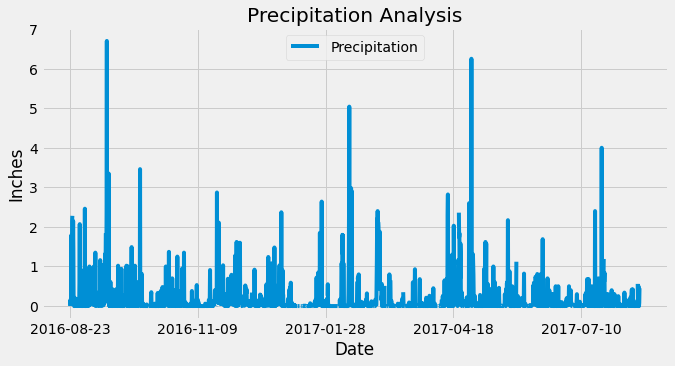

In [157]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation Analysis", figsize=(10,5))
plt.legend(loc='upper center')
plt.ylabel("Inches")
plt.savefig("Images/precipitation.png")
plt.show()

In [158]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [159]:
# Design a query to show how many stations are available in this dataset
num_stations = session.query(Station).count()
num_stations

9

In [160]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [161]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

min_max_avg_temp = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
min_max_avg_temp

[(54.0, 85.0, 71.66378066378067)]

In [162]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
most_active_station_data = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.date >= one_year_ago).\
                filter(Measurement.station == "USC00519281").\
                order_by(Measurement.date).all()

# Save a dataframe of the results
tobs_df = pd.DataFrame(most_active_station_data, columns=["Date","Temperature"])
tobs_df.set_index("Date", inplace=True,)
tobs_df.head(10)

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
2016-08-29,78.0
2016-08-30,77.0
2016-08-31,78.0


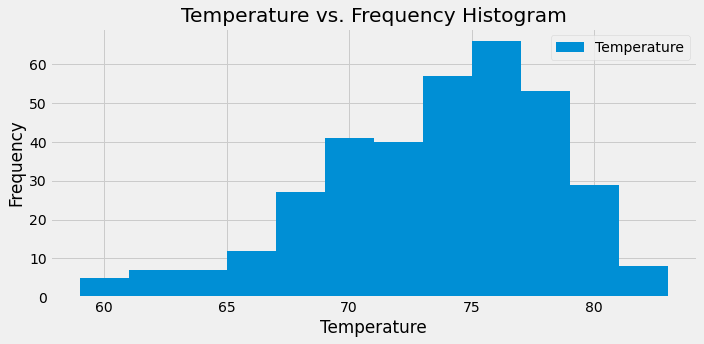

In [163]:
# Plot the results as a histogram
tobs_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", figsize=(10,5))
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Images/temperature_vs_frequency.png")
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

In [165]:
# Filter the dataframe to show June temperature data
date_str = "06"
june_temps = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == date_str).all()
june_temps

[('2010-06-01', 78.0),
 ('2010-06-02', 76.0),
 ('2010-06-03', 78.0),
 ('2010-06-04', 76.0),
 ('2010-06-05', 77.0),
 ('2010-06-06', 78.0),
 ('2010-06-07', 77.0),
 ('2010-06-08', 78.0),
 ('2010-06-09', 78.0),
 ('2010-06-10', 79.0),
 ('2010-06-11', 78.0),
 ('2010-06-12', 78.0),
 ('2010-06-13', 78.0),
 ('2010-06-14', 77.0),
 ('2010-06-15', 78.0),
 ('2010-06-16', 78.0),
 ('2010-06-17', 77.0),
 ('2010-06-18', 77.0),
 ('2010-06-19', 82.0),
 ('2010-06-20', 78.0),
 ('2010-06-21', 78.0),
 ('2010-06-22', 78.0),
 ('2010-06-23', 78.0),
 ('2010-06-24', 78.0),
 ('2010-06-25', 77.0),
 ('2010-06-26', 76.0),
 ('2010-06-27', 78.0),
 ('2010-06-28', 78.0),
 ('2010-06-29', 78.0),
 ('2010-06-30', 78.0),
 ('2011-06-01', 77.0),
 ('2011-06-02', 78.0),
 ('2011-06-03', 73.0),
 ('2011-06-04', 70.0),
 ('2011-06-05', 76.0),
 ('2011-06-06', 77.0),
 ('2011-06-07', 77.0),
 ('2011-06-08', 77.0),
 ('2011-06-09', 77.0),
 ('2011-06-10', 78.0),
 ('2011-06-11', 77.0),
 ('2011-06-12', 77.0),
 ('2011-06-13', 78.0),
 ('2011-06-

In [166]:
# Create Dataframe showing all June temperatures
june_temps_df = pd.DataFrame(june_temps, columns=["Date", "Temperature"])
june_temps_df.set_index("Date", inplace=True,)
june_temps_df

,Temperature
Date,
2010-06-01,78.0
2010-06-02,76.0
2010-06-03,78.0
2010-06-04,76.0
2010-06-05,77.0
...,...
2017-06-26,79.0
2017-06-27,74.0
2017-06-28,74.0


In [173]:
# Display the average temperature in June across all years:
june_avg_temp = june_temps_df.mean()
june_avg_temp

Temperature    74.944118
dtype: float64

In [168]:
# Filter the dataframe to show December temperature data
date_str = "12"
dec_temps = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == date_str).all()
dec_temps

[('2010-12-01', 76.0),
 ('2010-12-03', 74.0),
 ('2010-12-04', 74.0),
 ('2010-12-06', 64.0),
 ('2010-12-07', 64.0),
 ('2010-12-08', 67.0),
 ('2010-12-09', 77.0),
 ('2010-12-10', 66.0),
 ('2010-12-11', 69.0),
 ('2010-12-12', 68.0),
 ('2010-12-13', 68.0),
 ('2010-12-14', 71.0),
 ('2010-12-15', 74.0),
 ('2010-12-16', 67.0),
 ('2010-12-17', 66.0),
 ('2010-12-18', 69.0),
 ('2010-12-19', 71.0),
 ('2010-12-23', 70.0),
 ('2010-12-24', 70.0),
 ('2010-12-26', 74.0),
 ('2010-12-27', 74.0),
 ('2010-12-28', 71.0),
 ('2010-12-29', 75.0),
 ('2010-12-30', 75.0),
 ('2010-12-31', 72.0),
 ('2011-12-01', 69.0),
 ('2011-12-02', 68.0),
 ('2011-12-03', 73.0),
 ('2011-12-04', 74.0),
 ('2011-12-05', 73.0),
 ('2011-12-06', 73.0),
 ('2011-12-07', 73.0),
 ('2011-12-08', 73.0),
 ('2011-12-09', 71.0),
 ('2011-12-10', 73.0),
 ('2011-12-11', 73.0),
 ('2011-12-12', 77.0),
 ('2011-12-13', 72.0),
 ('2011-12-14', 71.0),
 ('2011-12-15', 73.0),
 ('2011-12-16', 70.0),
 ('2011-12-17', 73.0),
 ('2011-12-18', 69.0),
 ('2011-12-

In [169]:
# Create Dataframe showing all December temperatures
dec_temps_df = pd.DataFrame(dec_temps, columns=["Date", "Temperature"])
dec_temps_df.set_index("Date", inplace=True,)
dec_temps_df

,Temperature
Date,
2010-12-01,76.0
2010-12-03,74.0
2010-12-04,74.0
2010-12-06,64.0
2010-12-07,64.0
...,...
2016-12-27,71.0
2016-12-28,71.0
2016-12-29,69.0


In [174]:
# Display the average temperature in December across all years:
dec_avg_temp = dec_temps_df.mean()
dec_avg_temp

Temperature    71.041529
dtype: float64

In [175]:
#Import Stats to perform t-test
import scipy.stats as stats

In [179]:
# Length of June temp dataframe:
len(june_temps_df)

1700

In [180]:
# Length of December temp dataframe:
len(dec_temps_df)

1517

In [186]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
# Use an unpaired t-test because the sample sizes are different (1700 data points for June vs. 1517 for December)
stats.ttest_ind(june_temps_df.Temperature, dec_temps_df.Temperature, equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

A p-value of 4.19 means that there is not a statistically significant difference between Hawaii's average temperatures in June versus its average temperatures in December.

### Temperature Analysis II

In [105]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [213]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = '2016-08-01'
trip_end_date = '2017-08-08'

trip_temps = calc_temps('2016-08-01', '2016-08-08')
trip_temps

[(72.0, 78.03921568627452, 83.0)]

In [214]:
# Load the Results as a Pandas DataFrame
trip_df = pd.DataFrame(trip_temps, columns=["TMIN", "TAVG", "TMAX"])
trip_df

,TMIN,TAVG,TMAX
0,72.0,78.039216,83.0


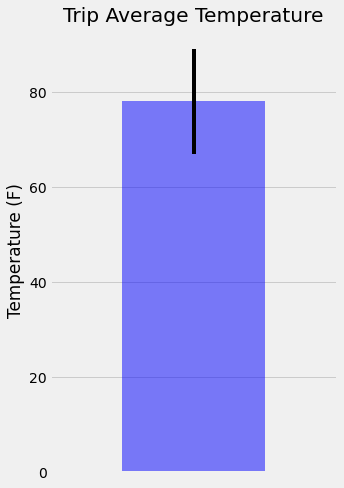

In [215]:
# Plot the min, avg, and max Temperatures from the Previous Query as a Bar Chart
# Use "Trip Average Temperature" as the Title
# Use the Average Temperature for the y Value
# Use the Peak-to-Peak (max-min) Value as the y Error Bar (yerr)
trip_df.plot.bar(y="TAVG", yerr=(trip_df["TMAX"] - trip_df["TMIN"]), 
                    title="Trip Average Temperature", color="blue", 
                    alpha=0.5, figsize=(5,7), legend=None)
plt.xticks([])
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig("Images/trip_average_temperature.png")
plt.show()

In [216]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

station_rain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= trip_start_date)
                   .filter(Measurement.date <= trip_end_date)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

#convert query object to data frame
station_rain_df = pd.DataFrame(np.array(stationRain))
#rename columns
station_rain_df = station_rain_df.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

station_rain_df

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",158.61000000000007,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",79.55000000000005,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",54.39000000000004,21.4234,-157.8015,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",39.800000000000004,21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",34.45999999999999,21.5213,-157.8374,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",17.21999999999999,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",4.77,21.3934,-157.9751,11.9


In [201]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [217]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2016-08-01"
end_date = "2019-08-08"
# Use the start and end date to create a range of dates
start_num = int(start_date[-2:])
end_num = int(end_date[-2:])
trip_length = end_num - start_num + 1

#start date as datetime object
start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')

# Stip off the year and save a list of %m-%d strings
date_list = [dt.datetime.strftime(start_date + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, trip_length)]

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_normals = [daily_normals(date) for date in date_list]

trip_normals

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)],
 [(68.0, 76.5576923076923, 83.0)]]

In [218]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

# Extract normals into a list of lists
trip_normals = [np.array(normal[0]) for normal in trip_normals]

# Convert normals list into a data frame
normals_df = pd.DataFrame(trip_normals)

# Add date column
normals_df["Date"] = dateList

# Set index and rename columns
normals_df = normals_df.set_index("Date")
normals_df = normals_df.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normals_df

,Low Temp,Avg Temp,High Temp
Date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0
08-08,68.0,76.557692,83.0


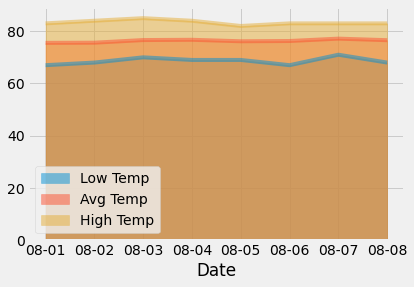

In [219]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, alpha=.5)